In [1]:
import numpy as np
import scipy.sparse as sp
from mpl_toolkits import mplot3d
from rom_am import ROM, DMD, KERDMDC, KERDMD, DMDc
import matplotlib.pyplot as plt
import scipy.interpolate as si

In [2]:
def create_data():
    oper = np.array([[0.54, 0.43], [0.35, 0.6]])
    nt = 901
    t_fin = 10
    dt = t_fin/(nt-1)
    input_t = np.linspace(0, t_fin, nt)
    input_data = np.empty((2, len(input_t)))
    input_data[:, 0] = np.array([0.9, 0.8])
    
    for i in range(len(input_t)-1):
        input_data[:, i+1] = oper @ input_data[:, i]
    
    return input_data, input_t, nt, dt

input_data, input_t, nt, dt = create_data()

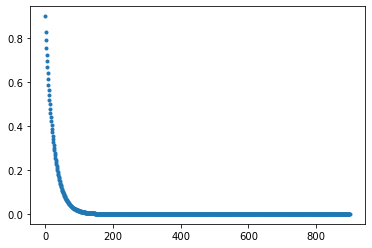

In [3]:
plt.plot(input_data[0, :], '.');

In [4]:
X = input_data[:, :-1]
Y = input_data[:, 1::]

In [5]:
dmd = DMD()
u, s, vh = dmd.decompose(X = X, Y= Y, dt = dt)

In [6]:
pred = dmd.predict(input_t, method=0)

In [7]:
pred1 = np.empty((X.shape[0], len(input_t)), dtype=complex)
pred1[:, 0] = dmd.init
b = np.linalg.pinv(dmd.dmd_modes) @ dmd.init

for i in range(len(input_t)-1):
    pred1[:, i+1] = (dmd.dmd_modes @ np.diag(dmd.lambd)**(i+1) @ b).ravel()


In [8]:
pred2 = np.empty((X.shape[0], len(input_t)), dtype=complex)
pred2[:, 0] = dmd.init
_, ksi = np.linalg.eig(dmd.A.T)

for i in range(len(input_t)-1):
    eigenfunc = ksi[:, ::-1].T @ pred2[:, i].reshape((-1, 1))
    pred2[:, i+1] = ((dmd.modes @ dmd.low_dim_eig) @ np.diag(dmd.lambd) @ eigenfunc).ravel()


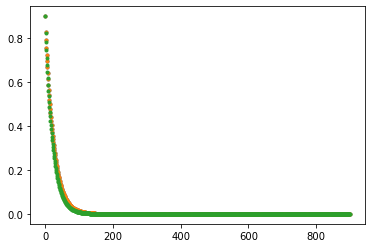

In [9]:
plt.plot(np.real(pred[0, :]), '.');
plt.plot(np.real(pred1[0, :]), '.');
plt.plot(np.real(pred2[0, :]), '.');

In [10]:
def create_data():
    lambdd = -1
    mu = -0.05
    oper = np.array([[mu, 0., 0.], [0., lambdd, -lambdd], [0., 0, 2*mu]])
    dt = 0.007
    input_t = np.arange(0, 2500, dt)
    init_data = np.array([2, -1])
    nonlinobs_init = np.array([init_data[0], init_data[1], init_data[0]**2])

    from scipy.integrate import solve_ivp
    def f(t, y): return oper @ y
    sol = solve_ivp(f, [0, input_t[-1]], nonlinobs_init, t_eval = input_t)
    input_data = sol.y.copy()
    
    return input_data, input_t, dt

input_data, input_t, dt = create_data()

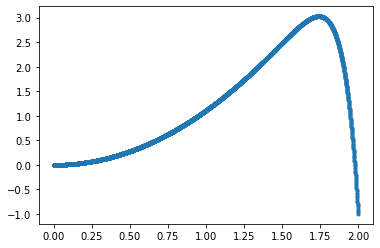

In [11]:
plt.plot(input_data[0, :], input_data[1, :], '.-');

In [12]:
X = input_data[:, :-1]
Y = input_data[:, 1::]

dmd = DMD()
u, s, vh = dmd.decompose(X = X, Y= Y, dt = dt)

In [13]:
B = np.array([[1, 0], [0, 1], [0, 0]])
prede = np.empty((2, len(input_t)), dtype=complex)
prede[:, 0] = dmd.init[:2]
LAMM, ksi = np.linalg.eig(dmd.A.T)
ksi = ksi/np.diag(ksi.T @ dmd.dmd_modes)

for i in range(len(input_t)-1):
    eigenfunc = ksi.T @ (np.array([prede[0, i], prede[1, i], prede[0, i]**2])).reshape((-1, 1))
    modes = ((dmd.dmd_modes).T @ B).T
    prede[:, i+1] = (modes @ np.diag(dmd.lambd) @ eigenfunc).ravel()

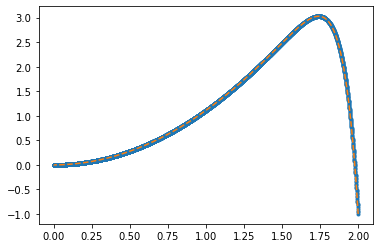

In [14]:
plt.plot(np.real(prede[0, :]), np.real(prede[1, :]), '.-');
plt.plot(input_data[0, :], input_data[1, :], '--');

In [15]:
prede2 = dmd.predict(t=input_t)

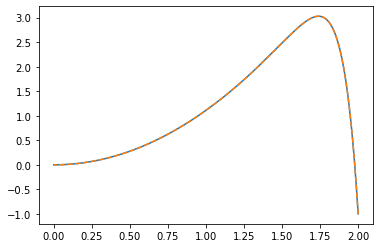

In [16]:
plt.plot(np.real(prede2[0, :]), np.real(prede2[1, :]), '-');
plt.plot(input_data[0, :], input_data[1, :], '--');

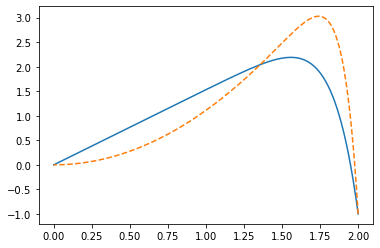

In [17]:
X = input_data[:2, :-1]
Y = input_data[:2, 1::]

dmd = DMD()
u, s, vh = dmd.decompose(X = X, Y= Y, dt = dt)
prede3 = dmd.predict(t=input_t)
plt.plot(np.real(prede3[0, :]), np.real(prede3[1, :]), '-');
plt.plot(input_data[0, :], input_data[1, :], '--');

In [18]:
def create_data():
    lambdd = -1
    mu = -0.05
    oper = np.array([[mu, 0., 0.], [0., lambdd, -lambdd], [0., 0, 2*mu]])
    dt = 0.09
    input_t = np.arange(0, 400, dt)
    init_data = np.array([2, -1])
    nonlinobs_init = np.array([init_data[0], init_data[1], init_data[0]**2])

    from scipy.integrate import solve_ivp
    def f(t, y): return oper @ y
    sol = solve_ivp(f, [0, input_t[-1]], nonlinobs_init, t_eval = input_t)
    input_data = sol.y.copy()
    
    return input_data, input_t, dt

input_data, input_t, dt = create_data()

In [19]:
X = input_data[:2, :-1]
Y = input_data[:2, 1::]

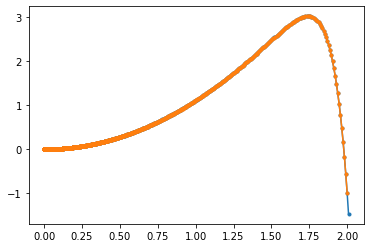

In [20]:
kdmd = KERDMD()
krom = ROM(kdmd)
krom.decompose(X = X, Y= Y, dt = dt, kernel="poly", p=2,)
predk = krom.predict(t=input_t, method=0)
plt.plot(np.real(predk[0, :]), np.real(predk[1, :]), '.-');
plt.plot(input_data[0, :], input_data[1, :], '.-');

In [21]:
prede = np.empty((2, len(input_t)), dtype=complex)
prede[:, 0] = kdmd.init[:2]
LAMM, ksi = np.linalg.eig(kdmd.A.T)
idx = (np.abs(LAMM)).argsort()[::-1]
ksi = ksi[:, idx]
ksi = ksi/np.diag(ksi.T @ kdmd.low_dim_eig)

for i in range(len(input_t)-1):
    x = prede[:, i].reshape((-1, 1))

    ff = (1 + x.T @ X)**2

    eigenfunc = (ff @ kdmd.time.T @ (np.diag(1/kdmd.singvals)) @ ksi).reshape((-1, 1))

    modes = (kdmd.dmd_modes)
    prede[:, i+1] = (modes @ np.diag(kdmd.lambd) @ eigenfunc).ravel()

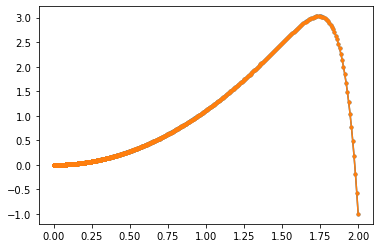

In [22]:
plt.plot(np.real(prede[0, :]), np.real(prede[1, :]), '.-');
plt.plot(input_data[0, :], input_data[1, :], '.-');

In [26]:
def create_data():
    lambdd = -1
    mu = -0.05
    oper = np.array([[mu, 0., 0.], [0., lambdd, -lambdd], [0., 0, 2*mu]])
    dt = 0.007
    input_t = np.arange(0, 2500, dt)
    init_data = np.array([2, -1])
    nonlinobs_init = np.array([init_data[0], init_data[1], init_data[0]**2])
    operB = np.array([[1], [0], [0]])
    
    def u(t) : return np.array([0.7])
    from scipy.integrate import solve_ivp
    def f(t, y): return oper @ y + operB @ u(t)
    sol = solve_ivp(f, [0, input_t[-1]], nonlinobs_init, t_eval = input_t)
    input_data = sol.y.copy()
    
    return input_data, input_t, dt

input_data, input_t, dt = create_data()

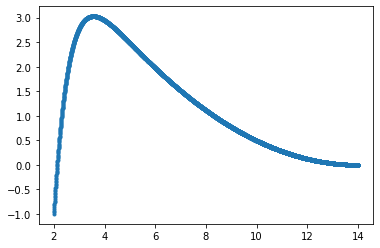

In [27]:
plt.plot(input_data[0, :], input_data[1, :], '.-');

In [28]:
X = input_data[:, :-1]
Y = input_data[:, 1::]

In [29]:
u_input = 0.7 * np.ones((1, X.shape[1]))
dmdc = DMDc()
_, s, v = dmdc.decompose(X,  Y = Y, dt = dt, Y_input=u_input)
predc = dmdc.predict(t=0, u_input=u_input)

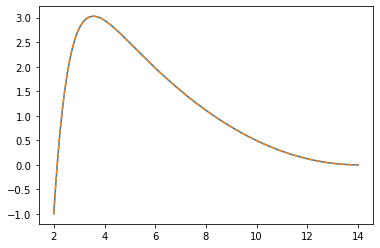

In [30]:
plt.plot(np.real(predc[0, :]), np.real(predc[1, :]), '-');
plt.plot(input_data[0, :], input_data[1, :], '--');

In [31]:
X = input_data[:2, :-1]
Y = input_data[:2, 1::]

In [32]:
u_input = 0.7 * np.ones((1, X.shape[1]))
dmdc = DMDc()
_, s, v = dmdc.decompose(X,  Y = Y, dt = dt, Y_input=u_input)
predc = dmdc.predict(t=0, u_input=u_input)

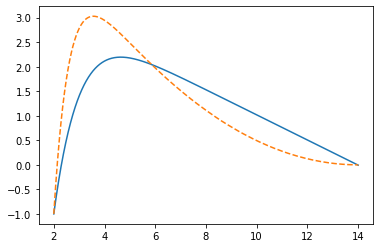

In [33]:
plt.plot(np.real(predc[0, :]), np.real(predc[1, :]), '-');
plt.plot(input_data[0, :], input_data[1, :], '--');

In [34]:
X = np.vstack((input_data[:, :-1], u_input))
Y = np.vstack((input_data[:, 1::], np.zeros((1, input_data.shape[1]-1))))

In [35]:
dmd = DMD()
u, s, vh = dmd.decompose(X = X, Y= Y, dt = dt)

predc = np.empty((3, u_input.shape[1]), dtype=complex)
predc[:, 0] = dmd.init[:3]

for i in range(predc.shape[1]-1):
    predc[:, i+1] = (dmd.A @ np.array([predc[0, i], predc[1, i], predc[2, i], u_input[0, i]]))[:3]

/Users/azzeddinetiba/opt/anaconda3/lib/python3.9/site-packages/rom_am/dmd.py:170: RuntimeWarning: divide by zero encountered in log
  omega = np.log(lambd) / dt  # Continuous system eigenvalues


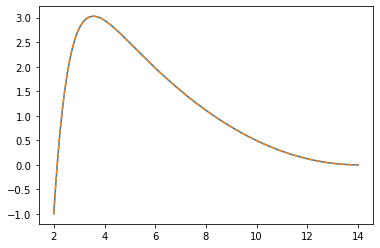

In [36]:
plt.plot(np.real(predc[0, :]), np.real(predc[1, :]), '-');
plt.plot(input_data[0, :], input_data[1, :], '--');

In [37]:
def create_data():
    lambdd = -1
    mu = -0.05
    oper = np.array([[mu, 0., 0.], [0., lambdd, -lambdd], [0., 0, 2*mu]])
    dt = 0.7
    input_t = np.arange(0, 2500, dt)
    init_data = np.array([2, -1])
    nonlinobs_init = np.array([init_data[0], init_data[1], init_data[0]**2])
    operB = np.array([[1], [0], [0]])
    
    def u(t) : return np.array([0.7])
    from scipy.integrate import solve_ivp
    def f(t, y): return oper @ y + operB @ u(t)
    sol = solve_ivp(f, [0, input_t[-1]], nonlinobs_init, t_eval = input_t)
    input_data = sol.y.copy()
    
    return input_data, input_t, dt

input_data, input_t, dt = create_data()

In [38]:
u_input = 0.7 * np.ones((1, input_data.shape[1]-1))
X = np.vstack((input_data[:2, :-1], u_input))
Y = np.vstack((input_data[:2, 1::], np.zeros((1, input_data.shape[1]-1))))

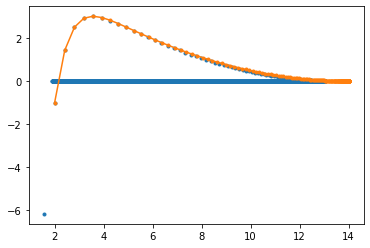

In [40]:
kdmd = KERDMD()
krom = ROM(kdmd)
krom.decompose(X = X, Y= Y, dt = dt, kernel="poly", p=2, normalize=True)
predk = krom.predict(t=input_t, method=0)
plt.plot(np.real(predk[0, :]), np.real(predk[1, :]), '.');
plt.plot(input_data[0, :], input_data[1, :], '.-');

In [51]:
prede = np.empty((2, u_input.shape[1]), dtype=complex)
prede[:, 0] = kdmd.init[:2]
LAMM, ksi = np.linalg.eig(kdmd.A.T)
idx = (np.abs(LAMM)).argsort()[::-1]
ksi = ksi[:, idx]
ksi = ksi/np.diag(ksi.T @ kdmd.low_dim_eig)

for i in range(u_input.shape[1]-1):
    x = np.array([prede[0, i], prede[1, i], 0.0167342]).reshape((-1, 1))
    ff = (1 + x.T @ krom.snapshots)**2

    eigenfunc = (ff @ kdmd.time.T @ (np.diag(1/kdmd.singvals)) @ ksi).reshape((-1, 1))

    modes = (kdmd.dmd_modes)
    prede[:, i+1] = (modes @ np.diag(kdmd.lambd) @ eigenfunc).ravel()[:2]
prede = krom._denormalize(np.vstack((prede, np.ones((1, prede.shape[1])))))

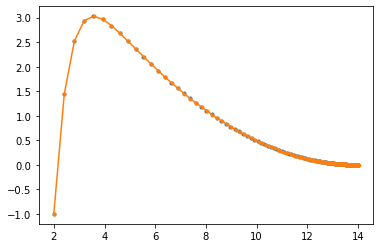

In [52]:
plt.plot(np.real(prede[0, :]), np.real(prede[1, :]), '.');
plt.plot(input_data[0, :], input_data[1, :], '.-');

In [69]:
u_input = np.random.randn(1, len(input_t)-1)
from scipy import interpolate
p_ = interpolate.interp1d(
    input_t[:-1], u_input, fill_value="extrapolate")
def p(t): return p_(t).astype(float)

def create_data():
    lambdd = -1
    mu = -0.05
    oper = np.array([[mu, 0., 0.], [0., lambdd, -lambdd], [0., 0, 2*mu]])
    dt = 0.7
    input_t = np.arange(0, 2500, dt)
    init_data = np.array([2, -1])
    nonlinobs_init = np.array([init_data[0], init_data[1], init_data[0]**2])
    operB = np.array([[1], [0], [0]])
    
    def u(t) : return np.array([0.7])
    from scipy.integrate import solve_ivp
    def f(t, y): return oper @ y + operB @ p(t)
    sol = solve_ivp(f, [0, input_t[-1]], nonlinobs_init, t_eval = input_t)
    input_data = sol.y.copy()
    
    return input_data, input_t, dt

input_data, input_t, dt = create_data()
X = np.vstack((input_data[:2, :-1], u_input))
Y = np.vstack((input_data[:2, 1::], np.zeros((1, input_data.shape[1]-1))))

kdmd = KERDMD()
krom = ROM(kdmd)
krom.decompose(X = X, Y= Y, dt = dt, kernel="poly", p=2, normalize=True)

In [70]:
prede = np.empty((2, u_input.shape[1]), dtype=complex)
prede[:, 0] = kdmd.init[:2]
LAMM, ksi = np.linalg.eig(kdmd.A.T)
idx = (np.abs(LAMM)).argsort()[::-1]
ksi = ksi[:, idx]
ksi = ksi/np.diag(ksi.T @ kdmd.low_dim_eig)

for i in range(u_input.shape[1]-1):
    x = np.array([prede[0, i], prede[1, i], krom.snapshots[-1, i]]).reshape((-1, 1))
    ff = (1 + x.T @ krom.snapshots)**2

    eigenfunc = (ff @ kdmd.time.T @ (np.diag(1/kdmd.singvals)) @ ksi).reshape((-1, 1))

    modes = (kdmd.dmd_modes)
    prede[:, i+1] = (modes @ np.diag(kdmd.lambd) @ eigenfunc).ravel()[:2]
prede = krom._denormalize(np.vstack((prede, np.ones((1, prede.shape[1])))))

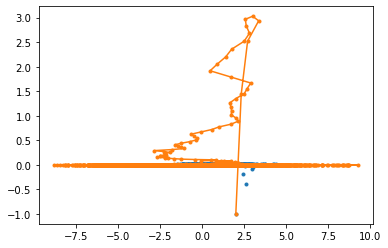

In [71]:
plt.plot(np.real(prede[0, :]), np.real(prede[1, :]), '.');
plt.plot(input_data[0, :], input_data[1, :], '.-');